# 주제: 데이터속에 숨어있는 해외주식 투자기회 찾기

해외 주식 & 뉴스 데이터를 활용하여 국내/해외 종목 간의 상관관계 분석

* URL : https://dacon.io/competitions/official/236145/overview/description


`**제공된 데이터셋**`

`NASDAQ_FC_STK_IEM_IFO.csv`

* 2023년 1월 1일 부터 2023년 8월 31일까지 미국 나스닥 거래소에서 시세를 제공하는 주문 가능한 종목 정보
* ISIN_IEM_CD : ISIN 코드
* TCK_IEM_CD : 종목 티커 코드
* FC_SEC_KRL_NM : 해외주식 종목 한글명
* FC_SEC_ENG_NM : 해외주식 종목 영문명



`NASDAQ_DT_FC_STK_QUT.csv`

* 2023년 1월 1일부터 2023년 8월 31일까지 NASDAQ_FC_STK_IEM_IFO.csv에 있는 종목의 시세 정보
* TRD_DT : 거래일자
* TCK_IEM_CD : 티커종목코드
* IEM_ONG_PR : 종목시가
* IEM_HI_PR : 종목고가
* IEM_LOW_PI : 종목저가
* IEM_END_PR : 종목종가
* ACL_TRD_ATY : 누적거래수량
* SLL_CNS_SUM_QTY : 매도체결합계수량
* BYN_CNS_SUM_QTY : 매수체결합계수량


<전체적 분석 Outline>

1. 데이터 수집 및 전처리 : NASDAQ 홈페이지에 Stock Screener페이지를 활용하여 RSS피드에 나오는 회사의 부가적인 정보를 획득하였으며 Stock Screener 페이지의 섹터를 활용하여 RSS피드 데이터를 각각의 섹터로 구분한 후 섹터 안 산업군을 임의로 분류하여 적용하였습니다. 또한  RSS 데이터의 URL 컬럼을 통해 뉴스 본문을 크롤링하여 감성분석에 활용하기 위해 소문자 변환, punctuation제거, 토큰화, 불용어 제거 등을 적용하여 전처리를 진행하였습니다.
2. 워드 클라우드를 활용한 뉴스별 주요 단어 확인하기 : 감성분석을 적용하기 전 크롤링한 뉴스에서 어떤 단어들이 주로 사용되었는지를 확인할 수 있도록  해당 코드에 확인하고 싶은 회사의 티커 코드와 해당 날짜를 입력하면 그날 발행된 뉴스의 많이 사용된 단어들을 워드클라우드 형태로 확인할 수 있습니다.
3. 감성분석과 주가변동 확인 : 크롤링한 뉴스 데이터를 감성분석을 진행하여 각각의 뉴스 데이터에 대해 긍정점수가 부정점수보다 높다면 해당 뉴스는 긍정으로 처리하였으며 긍정인 뉴스가 발행된 그다음 날과 당일의 주식 종가를 비교하여 해당 뉴스는 호재/악재인지 확인해 보았습니다.

#1. 데이터 살펴보기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 파일 저장 후 경로 지정
PATH = '/content/'
READ_PATH = '/content/drive/MyDrive/2023NH공모전/FINAL/'

nasdaq_rss_ifo 데이터

In [ ]:
!pip install newspaper3k

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13538 sha256=bdfa046e623d9750e49d626378c8b0064f7794091206e94591f7ae3393f4bd66
  Stored in directory: /root/.cache/pip/wheels/c8/d6/6c/384f58df48c00b9a31d638005143b5b3ac62c3d25fb1447f23
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3340 sha256=dfa140ac1f45324c24f76a82221216acf5b34dd5b61df7a7055b47e7e87db0f0
  Stored in directory: /root/.cache/pip/wheels/97/02/e7/a1ff1760e12bdbaab0ac824fae5c1b

In [ ]:
from newspaper import Article
import numpy as np
import pandas as pd
import time
import os
import re

In [ ]:
nasdaq_df = pd.read_csv(os.path.join(READ_PATH, 'nasdaq_df_wo_text.csv'))
nasdaq_df.shape

(88602, 9)

In [ ]:
def extract_text(url):

    article = Article(url)
    article.download()
    article.parse()
    text = article.text or 'N/A' #text가 없는 경우 'N/A'로 출력

    return text

In [ ]:
nasdaq_df['text'] = None  # 'text'열을 None으로 초기화

In [ ]:
nasdaq_df['text'].isna()

0        True
1        True
2        True
3        True
4        True
         ... 
88597    True
88598    True
88599    True
88600    True
88601    True
Name: text, Length: 88602, dtype: bool

## KRX 데이터

In [106]:
all_krx_adj_close = pd.read_csv(READ_PATH + 'krx_adj_close.csv', index_col=0, parse_dates=True)
all_krx_adj_close.head()

,A098120,A009520,A095570,A006840,A282330,A027410,A138930,A001465,A001460,A001045,...,A084110,A145020,A024060,A010240,A189980,A000545,A000540,A003280,A037440,A238490
date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,5120.0,7710,5720.0,16250,202000.0,4115.0,6300.0,141000,368500,49300,...,18100.0,134400.0,5520,5340.0,2600.0,6140,3385,1320,7930,6060.0
2023-01-03,5160.0,7740,5790.0,16200,199000.0,4100.0,6340.0,141000,374000,49000,...,18200.0,134500.0,5470,5340.0,2595.0,6000,3355,1310,8000,6060.0
2023-01-04,5480.0,7760,5760.0,16250,197500.0,4155.0,6550.0,141500,371500,48650,...,18350.0,128700.0,5510,5720.0,2645.0,6120,3440,1330,8250,6180.0
2023-01-05,5570.0,7540,5760.0,16400,192000.0,4230.0,6720.0,142500,371500,48200,...,18350.0,132200.0,5500,6050.0,2635.0,6320,3430,1325,10700,6100.0
2023-01-06,5670.0,7570,5720.0,16050,191500.0,4225.0,6790.0,142000,370500,48350,...,19150.0,132600.0,5580,6040.0,2840.0,6260,3395,1465,11100,6150.0


In [108]:
all_krx_adj_open = pd.read_csv(READ_PATH + 'krx_adj_open.csv', index_col=0, parse_dates=True)
all_krx_adj_open.head()

,A098120,A009520,A095570,A006840,A282330,A027410,A138930,A001465,A001460,A001045,...,A084110,A145020,A024060,A010240,A189980,A000545,A000540,A003280,A037440,A238490
date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,5130.0,7990,5720.0,17250,212500.0,4255.0,6450.0,141500,367000,49750,...,18550.0,135200.0,5620,5620.0,2670.0,6250,3400,1325,8160,6200.0
2023-01-03,5010.0,7730,5790.0,15900,205000.0,4085.0,6260.0,140000,383000,48800,...,18000.0,137000.0,5420,5240.0,2560.0,6100,3360,1305,7860,5900.0
2023-01-04,5080.0,7670,5700.0,16250,199000.0,4110.0,6340.0,141000,370500,48800,...,17800.0,134500.0,5400,5290.0,2550.0,6090,3350,1310,7990,5850.0
2023-01-05,5560.0,7760,5760.0,16500,195000.0,4150.0,6560.0,141000,376500,48650,...,18400.0,129400.0,5520,5780.0,2555.0,6300,3440,1335,8170,6230.0
2023-01-06,5570.0,7500,5690.0,16100,188500.0,4190.0,6640.0,142500,368500,48550,...,18350.0,132200.0,5460,6090.0,2650.0,6230,3480,1325,10250,6090.0


## NASDAQ 데이터

In [110]:
import requests

def get_nasdaq_index_ohlc(start, end, only_close=True):
    """네이버에서 나스닥 종합 지수 데이터를 수집하여 반환"""
    start_nvr_format = start.replace('-','.')
    end_nvr_format = end.replace('-','.')
    page = 1

    nasdaq_ohlcv = pd.DataFrame()
    while True:
        url = f'https://finance.naver.com/world/sise.naver?symbol=NAS@IXIC&page={page}'
        html = requests.get(url, headers={'User-agent' : 'Mozilla/5.0'}).text
        temp_ohlcv = pd.read_html(html)[1]
        nasdaq_ohlcv = pd.concat([nasdaq_ohlcv, temp_ohlcv], axis=0)
        if start_nvr_format > temp_ohlcv['일자'].iloc[-1]:
            break
        page += 1

    nasdaq_ohlcv.columns = ['date','close','diff','open','high','low']
    nasdaq_ohlcv.set_index('date', drop=True, inplace=True)
    nasdaq_ohlcv = nasdaq_ohlcv.iloc[::-1]
    nasdaq_ohlcv.index = pd.to_datetime(nasdaq_ohlcv.index)
    nasdaq_ohlcv = nasdaq_ohlcv.loc[start:end,:]
    if only_close:
        return nasdaq_ohlcv.close
    return nasdaq_ohlcv

In [111]:
nsd_idx_close = get_nasdaq_index_ohlc(start='2023-01-01', end='2023-08-30', only_close=True)
nsd_idx_close.head()

date
2023-01-03    10386.99
2023-01-04    10458.76
2023-01-05    10305.24
2023-01-06    10569.29
2023-01-09    10635.65
Name: close, dtype: float64

#2. 데이터 전처리

*   CNBC 경제 뉴스 사이트에서 최근 인기 있는 기사 토픽을 파악하고자 함.
*   대회 시작 당시 9월 초였기에 '최근'의 기준을 8월 1달로 한정함.

In [ ]:
!pip install bertopic
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 25.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.2 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039274 sha256=9ec816ffe718f70b1007857354ac554960e232fde668ad3a1e8ea01abf33947b
  Stored in di

In [ ]:
!pip install "tensorflow==2.15.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.0
    Uninstalling te

In [ ]:
import os

# #전처리 패키지
import pandas as pd
import numpy as np
from datetime import datetime
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# #토픽 모델링 패키지
from sentence_transformers import SentenceTransformer
# from umap.umap_ import UMAP
from bertopic import BERTopic
import hdbscan
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from bertopic.representation import MaximalMarginalRelevance

#interactive plot 시각화
import plotly.express as px

import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [ ]:
df = pd.read_pickle(os.path.join(READ_PATH, 'cnbc_newsdata_final.pkl'))
df.head()

,title,date,category,key_points,text,url
0,‘I work just 5 hours a week': A 39-year-old wh...,2023-01-01,Success,N/A,"Graham Cochrane, Founder of The Recording Revo...",https://www.cnbc.com/2023/01/01/39-year-old-wh...
1,Chinese state media seek to reassure public ov...,2023-01-01,Asia-Pacific News,Chinese state media sought to reassure the pub...,Revelers prepare to release balloons to celebr...,https://www.cnbc.com/2023/01/01/chinese-state-...
2,Should you get creative with your resume? Expe...,2023-01-01,Land the Job,N/A,Mature businessman congratulating young profes...,https://www.cnbc.com/2023/01/01/cv-will-a-crea...
3,Market misery deals sovereign wealth funds his...,2023-01-01,Markets,Heavy falls in stock and bond markets over the...,A trader works on the floor of the New York St...,https://www.cnbc.com/2023/01/01/market-misery-...
4,More social media regulation is coming in 2023...,2023-01-01,Tech,Days after Congress passed a bipartisan spendi...,"The U.K.'s Online Safety Bill, which aims to r...",https://www.cnbc.com/2023/01/01/more-social-me...


In [ ]:
df = df[df['date'].dt.strftime('%Y-%m') != '2023-09']

## 카테고리 값 중 월별로 5회 미만 언급된 기사 drop



*   월에 5번도 언급되지 않은 카테고리는 주가 분석에 있어 중요하지 않은 기사라고 판단해 삭제함.



In [ ]:
# 'date' 컬럼에서 월 정보를 추출하여 'month' 컬럼 생성
df['month'] = df['date'].dt.month

# 월 별로 카테고리 등장 횟수 계산
monthly_counts = df.groupby(['month', 'category']).size().reset_index(name='count')

# 월 별로 5번 이상 등장한 카테고리 찾기
valid_categories = monthly_counts[monthly_counts['count'] >= 5]['category'].unique()

final_df = df[df['category'].isin(valid_categories)]

# 결과 출력
final_df.head()

,title,date,category,key_points,text,url,month
0,‘I work just 5 hours a week': A 39-year-old wh...,2023-01-01,Success,N/A,"Graham Cochrane, Founder of The Recording Revo...",https://www.cnbc.com/2023/01/01/39-year-old-wh...,1
1,Chinese state media seek to reassure public ov...,2023-01-01,Asia-Pacific News,Chinese state media sought to reassure the pub...,Revelers prepare to release balloons to celebr...,https://www.cnbc.com/2023/01/01/chinese-state-...,1
2,Should you get creative with your resume? Expe...,2023-01-01,Land the Job,N/A,Mature businessman congratulating young profes...,https://www.cnbc.com/2023/01/01/cv-will-a-crea...,1
3,Market misery deals sovereign wealth funds his...,2023-01-01,Markets,Heavy falls in stock and bond markets over the...,A trader works on the floor of the New York St...,https://www.cnbc.com/2023/01/01/market-misery-...,1
4,More social media regulation is coming in 2023...,2023-01-01,Tech,Days after Congress passed a bipartisan spendi...,"The U.K.'s Online Safety Bill, which aims to r...",https://www.cnbc.com/2023/01/01/more-social-me...,1


In [ ]:
# 2023년 8월 이후 데이터만 선택
start_date = '2023-08-01'
final_df = final_df[final_df['date'] >= start_date]

final_df.date

4946   2023-08-01
4947   2023-08-01
4948   2023-08-01
4949   2023-08-01
4950   2023-08-01
          ...    
5625   2023-08-31
5626   2023-08-31
5627   2023-08-31
5628   2023-08-31
5630   2023-08-31
Name: date, Length: 616, dtype: datetime64[ns]

##토큰화 및 불용어 제거

- 크롤링 데이터의 특수문자와 문장부호 제거
- 불용어 제거(n차 토픽모델링 후 후처리 진행)
- 불용어 제거 및 토큰화 : 상업용으로 사용하기에 사용성과 성능 면에서 nltk보다 spacy가 우수해 spacy 모델을 사용했다. 긴 텍스트(기사 본문)를 처리해야 하므로 en_core_web_lg 모델을 사용했다. 또한 tokenizer 함수를 생성할 때는 명사만 추출하도록 했으며, 개체명은 'TIME','CARDINAL','DATE'을 제외한 모든 entity를 사용했다.

In [ ]:
# 특수 문자와 문장 부호 제거 함수 정의
def remove_special_characters(text):
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    return cleaned_text

# 데이터 전처리 함수 적용
final_df['text'] = final_df['text'].apply(remove_special_characters)

In [ ]:
#spacy 모델 다운로드
!python -m spacy download en_core_web_lg

2023-12-26 10:27:34.165195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 10:27:34.165251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 10:27:34.166583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 10:27:35.208051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 3.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
#spacy 모델 정의
nlp = spacy.load("en_core_web_lg")

#불용어 리스트
spacy_stopwords_list = list(nlp.Defaults.stop_words)

#처리할 문자열 최대 길이
nlp.max_length = 10000000

#토픽모델링 후 추가 불용어 삭제
new_stopwords_list = ['cnbc', 'share', 'earning', 'revenue', 'premarket', 'stock', 'chart icon', 'stock chart', 'chart', 'icon', 'company', 'store', 'wedding', 'food', 'economy', 'bank']
spacy_stopwords_list_new = spacy_stopwords_list + new_stopwords_list

In [ ]:
#tokenizer 함수 생성
#1. 명사 추출
#2. 소문자 변환
#3. 불용어 제거
#4. 개체명 time, cardinal, date 제거
def tokenizer(text):
    words=[]
    doc=nlp(text)
    for token in doc:
        if token.tag_[0] in ['N'] and token.lemma_.lower() not in spacy_stopwords_list_new and token.ent_type_ not in ['TIME','CARDINAL','DATE']:
                if len(token.lemma_.lower())>1:
                    words.append(token.lemma_.lower())

    return words

##국내/해외 데이터 Preprocessing

In [109]:
all_stocks_cnt = all_krx_adj_close.shape[1]

# 기간 중 전기간 상장되어 있던 종목
krx_null_cnt = all_krx_adj_close.isnull().sum(axis=0)
is_all_period_listed = (krx_null_cnt == 0)
period_listed_stocks = is_all_period_listed[is_all_period_listed].index.values
period_listed_stocks_cnt = period_listed_stocks.shape[0]

# 기간 중 거래정지 종목 제외
trd_stop = (all_krx_adj_open == 0).sum()
trd_stop_stocks = trd_stop[trd_stop>0].index.values
trd_stop_stocks_cnt = trd_stop_stocks.shape[0]

cond_stocks = np.setdiff1d(period_listed_stocks, trd_stop_stocks)
cond_stocks_cnt = cond_stocks.shape[0]

print(f'현재 상장 종목: {all_stocks_cnt}')
print(f'- 기간 중 상장 및 폐지 종목: {all_stocks_cnt - period_listed_stocks_cnt}')
print(f'- 기간 중 거래정지 종목: {trd_stop_stocks_cnt}')
print(f'제거율: {1 - cond_stocks_cnt/all_stocks_cnt:.2%}')
print()
print(f'분석 대상 종목: {cond_stocks_cnt}')


krx_adj_close = all_krx_adj_close.loc[:, cond_stocks]
krx_adj_open = all_krx_adj_open.loc[:, cond_stocks]

현재 상장 종목: 2754
- 기간 중 상장 및 폐지 종목: 103
- 기간 중 거래정지 종목: 289
제거율: 13.91%

분석 대상 종목: 2371


In [113]:
nsd_idx_rtn_1d = nsd_idx_close.pct_change(1)
nsd_idx_rtn_1d

date
2023-01-03         NaN
2023-01-04    0.006910
2023-01-05   -0.014679
2023-01-06    0.025623
2023-01-09    0.006279
                ...   
2023-08-24   -0.018735
2023-08-25    0.009409
2023-08-28    0.008423
2023-08-29    0.017412
2023-08-30    0.005418
Name: close, Length: 166, dtype: float64

In [114]:
krx_rtn_1d = krx_adj_close / krx_adj_open - 1
krx_rtn_1d.head()

,A000020,A000040,A000050,A000070,A000075,A000080,A000087,A000100,A000105,A000120,...,A900340,A950110,A950130,A950140,A950160,A950170,A950190,A950200,A950210,A950220
date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,0.010638,0.000000,0.000000,-0.024745,-0.001802,-0.046875,-0.023952,-0.022530,0.007326,-0.043113,...,0.000000,0.008986,-0.040000,-0.005929,-0.010056,-0.039216,-0.028000,-0.046036,-0.013736,0.009950
2023-01-03,-0.025424,-0.031524,-0.023041,0.009023,0.003630,-0.002070,-0.015198,-0.017668,-0.025455,-0.020742,...,0.003012,-0.005135,-0.012397,0.038229,-0.012346,-0.010000,0.012500,0.031039,0.004196,0.011180
2023-01-04,0.008649,-0.010772,0.000000,0.014793,0.007220,0.010460,0.003086,-0.012522,-0.003731,-0.028793,...,0.027190,0.000000,0.025532,0.000000,0.025434,0.010204,0.033473,-0.005215,0.026836,-0.038601
2023-01-05,-0.002134,-0.017889,-0.023148,0.015965,-0.001786,-0.012295,0.006154,-0.007246,0.001873,0.018244,...,0.009852,-0.058824,0.004049,0.009597,0.011274,0.028860,-0.011952,0.029870,0.008345,-0.004975
2023-01-06,0.000000,0.001825,0.009479,-0.010000,0.000000,0.008316,-0.006135,0.000000,0.011215,0.014874,...,0.029703,0.046070,0.008097,-0.022857,0.018994,-0.034341,0.012245,-0.030612,-0.002782,0.011392


In [115]:
def get_nasdaq_data_matching_krx(krx_rtn_1d, nsd_idx_rtn_1d):
    """한국 시장 개장일에 맞춰 분석할 수 있는 나스닥 데이터 반환"""
    nsd_idx_rtn_1d_sft = nsd_idx_rtn_1d.shift(1)
    nsd_idx_rtn_1d_sft.dropna(inplace=True)

    krx_open_date = krx_rtn_1d.loc[nsd_idx_rtn_1d_sft.index[0]:nsd_idx_rtn_1d_sft.index[-1],:].index
    analysis_nsd_sr = pd.Series(name = 'NASDAQ', index=krx_open_date, dtype=np.float64)
    analysis_nsd_sr.iloc[0] = nsd_idx_rtn_1d_sft.iloc[0]

    prev_date = krx_open_date[0]
    for date in krx_open_date[1:]:
        closed_day_rtn = nsd_idx_rtn_1d_sft.loc[prev_date:date].iloc[1:]
        open_cond = closed_day_rtn.shape[0]
        analysis_nsd_sr.loc[date] = ((closed_day_rtn + 1).prod() - 1) if open_cond else np.nan
        prev_date = date
    analysis_nsd_sr.dropna(inplace=True)
    return analysis_nsd_sr

In [116]:
nsd_idx_rtn_match_krx = get_nasdaq_data_matching_krx(krx_rtn_1d, nsd_idx_rtn_1d)
nsd_idx_rtn_match_krx.head()

date
2023-01-05    0.006910
2023-01-06   -0.014679
2023-01-09    0.025623
2023-01-10    0.006279
2023-01-11    0.010059
Name: NASDAQ, dtype: float64

In [117]:
# 나스닥 정보에 맞추어 KRX 기간 처리 후 병합
krx_rtn_1d = krx_rtn_1d.loc[nsd_idx_rtn_match_krx.index, :]
rtn_1d = pd.concat([krx_rtn_1d, nsd_idx_rtn_match_krx], axis=1)
rtn_1d.head()

,A000020,A000040,A000050,A000070,A000075,A000080,A000087,A000100,A000105,A000120,...,A950110,A950130,A950140,A950160,A950170,A950190,A950200,A950210,A950220,NASDAQ
date,,,,,,,,,,,,,,,,,,,,,
2023-01-05,-0.002134,-0.017889,-0.023148,0.015965,-0.001786,-0.012295,0.006154,-0.007246,0.001873,0.018244,...,-0.058824,0.004049,0.009597,0.011274,0.028860,-0.011952,0.029870,0.008345,-0.004975,0.006910
2023-01-06,0.000000,0.001825,0.009479,-0.010000,0.000000,0.008316,-0.006135,0.000000,0.011215,0.014874,...,0.046070,0.008097,-0.022857,0.018994,-0.034341,0.012245,-0.030612,-0.002782,0.011392,-0.014679
2023-01-09,0.004233,0.000000,0.009346,0.007163,-0.005310,0.038855,0.000000,0.023593,0.003683,0.010033,...,0.014103,-0.012000,0.011494,0.018579,0.033994,0.000000,-0.032258,0.057343,-0.001239,0.025623
2023-01-10,-0.007400,-0.012567,-0.004630,0.005682,0.001779,0.007874,0.012232,-0.017794,0.001842,-0.014365,...,-0.006281,-0.024291,-0.034091,0.110515,-0.022973,-0.007968,-0.001328,-0.020779,-0.011236,0.006279
2023-01-11,-0.001055,-0.001812,0.000000,-0.007072,-0.001773,-0.007752,0.000000,-0.009025,0.005566,0.001116,...,-0.024020,-0.008230,-0.005803,-0.014634,-0.021622,0.008000,0.006579,-0.007895,0.008816,0.010059


In [118]:
# 결측치 확인
rtn_1d.isnull().sum().sum()

0

# 3. HOT TOPIC 및 관련 기업 찾기

##토픽 모델링
굵은 텍스트
*   임베딩 모델 선정 기준 : sbert.net의 sentencetransformer 중 가장 Performance가 높은 모델(all-mpnet-base-v2) 선정
*   5배나 빠른 속도에 정확도가 높은 all-MiniLM-L6-v2로도 시도해봤지만 성능이 좋지 않았음.



In [ ]:
#topic_modeling data 생성
all_texts = final_df['text'].values #전체 뉴스 데이터
timestamps = final_df['date'].to_list() #뉴스 발행일자

In [ ]:
embedding_model = SentenceTransformer("all-mpnet-base-v2") #임베딩 모델
embeddings = embedding_model.encode(all_texts, show_progress_bar=True) #임베딩 미리 계산(파라미터 수정 용이 위함)

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

파라미터 튜닝 결과 아래의 파라미터로 하는 것이 가장 토픽을 잘 찾는다고 판단함.

- UMAP(n_neighbors=8, min_dist=0.1, n_components=2)
- HDBSCAN(min_cluster_size=5)
- TfidfVectorizer 사용 이유 : 단어의 빈도 뿐만 아니라, 그 단어가 전체 문서 집합에서 얼마나 중요한지를 고려하기에 토픽모델링 시에 해당 모델을 사용하는 것이 적합함.(문서 집합에서 단어의 출현 빈도만을 고려하는 CountVectorizer는 불용어까지 토픽 키워드로 선정할 수 있다고 판단.)
- MaximalMarginalRelevance 사용 이유 : 토픽의 키워드를 통해 관련주를 찾아내야 하므로, 토픽 키워드를 추출하는 것이 정교해야 한다고 판단함. 또한 diversity를 0.2로 설정해 토픽과 관련된 키워드를 다소 다양하게 뽑고자 했음.(여러 번의 시행착오 결과 최적의 파라미터가 0.2라고 판단.)

In [ ]:
from umap.umap_ import UMAP

def pipeline_models():
    # UMAP 모델 정의
    umap_model = UMAP(n_neighbors=8, min_dist=0.1, n_components=2, random_state=42, metric='cosine')

    # HDBSCAN 모델 정의
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

    # TfidfVectorizer 모델 정의
    vectorizer_model = TfidfVectorizer(tokenizer=tokenizer, stop_words="english", ngram_range=(1, 2), min_df=2)

    # MaximalMarginalRelevance 모델 정의
    representation_model = MaximalMarginalRelevance(diversity=0.2)

    return umap_model, hdbscan_model, vectorizer_model, representation_model

# 모델 생성
umap_model, hdbscan_model, vectorizer_model, representation_model = pipeline_models()

def create_topic_model(embedding_model, umap_model, hdbscan_model, vectorizer_model, representation_model):
    # BERTopic 모델 정의
    topic_model = BERTopic(
        # Pipeline models
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        # Hyperparameters
        top_n_words=10,
        min_topic_size=5,
        verbose=True
    )

    return topic_model

# 모델 생성
topic_model = create_topic_model(embedding_model, umap_model, hdbscan_model, vectorizer_model, representation_model)

In [ ]:
topics, probs = topic_model.fit_transform(all_texts, embeddings)

2023-12-26 10:32:00,811 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2023-12-26 10:32:08,596 - BERTopic - Dimensionality - Completed ✓
2023-12-26 10:32:08,598 - BERTopic - Cluster - Start clustering the reduced embeddings
2023-12-26 10:32:08,618 - BERTopic - Cluster - Completed ✓
2023-12-26 10:32:08,623 - BERTopic - Representation - Extracting topics from clusters using representation models.
2023-12-26 10:33:37,817 - BERTopic - Representation - Completed ✓


In [ ]:
#share값과 토픽과 연관된 문장의 단어
def get_topic_stats(topic_model):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare', 'Name', 'Representation']]

In [ ]:
#상위 20개 토픽 추출
topic_stat = get_topic_stats(topic_model).head(20).set_index('Topic')
topic_stat

,Count,Share,CumulativeShare,Name,Representation
Topic,,,,,
-1,128,20.779221,20.779221,-1_bitcoin_resume_oracle_market,"[bitcoin, resume, oracle, market, sec, etf, ap..."
0,34,5.519481,26.298701,0_analyst refinitiv_analyst_cramer_price target,"[analyst refinitiv, analyst, cramer, price tar..."
1,29,4.707792,31.006494,1_ai_chatgpt_google_ai model,"[ai, chatgpt, google, ai model, openai, chatbo..."
2,28,4.545455,35.551948,2_retailer_walmart_foot locker_merchandise,"[retailer, walmart, foot locker, merchandise, ..."
3,24,3.896104,39.448052,3_pfizer_vaccine_pharmacy_medication,"[pfizer, vaccine, pharmacy, medication, obesit..."
4,24,3.896104,43.344156,4_cnn_disney_microsoft_activision,"[cnn, disney, microsoft, activision, espn, sal..."
5,23,3.733766,47.077922,5_election_president donald_indictment_case,"[election, president donald, indictment, case,..."
6,21,3.409091,50.487013,6_iphone_apple_ipad_smartphone,"[iphone, apple, ipad, smartphone, apple iphone..."
7,20,3.246753,53.733766,7_playlist_schwartz_taylor_feedback,"[playlist, schwartz, taylor, feedback, billion..."


## 기술 관련 토픽 키워드 확인

-> 토픽 0, 3, 6, 11, 15이 기술과 관련이 있다고 판단함


In [ ]:
topic_model.get_topic(0)

[('analyst refinitiv', 0.03372675178059123),
 ('analyst', 0.03358069195842215),
 ('cramer', 0.029788355301943913),
 ('price target', 0.02431798295350915),
 ('cent analyst', 0.02416615560766607),
 ('analyst factset', 0.01646362837866513),
 ('wall street', 0.01471902800971651),
 ('nvidia', 0.0134541032796249),
 ('refinitiv cent', 0.01326958911577641),
 ('trade alert', 0.013018680675714253)]

In [ ]:
topic_model.get_topic(3)

[('pfizer', 0.03984946568083507),
 ('vaccine', 0.036666046213431495),
 ('pharmacy', 0.031354301864470226),
 ('medication', 0.031088154769561154),
 ('obesity', 0.02947804525251283),
 ('novo', 0.023910544694010386),
 ('cvs', 0.02173974013150382),
 ('telegram', 0.020354560583392255),
 ('marketplace', 0.020174584958086234),
 ('covid', 0.017711835197507627)]

In [ ]:
topic_model.get_topic(6)

[('iphone', 0.12257195997513622),
 ('apple', 0.106950452167445),
 ('ipad', 0.04105567881255938),
 ('smartphone', 0.040866859685472635),
 ('apple iphone', 0.035399444958679),
 ('huawei', 0.03232852302698514),
 ('device', 0.03137481122840396),
 ('tablet', 0.02255925250547163),
 ('android', 0.02098821779092229),
 ('iphone model', 0.019903119080530076)]

In [ ]:
topic_model.get_topic(11)

[('oil', 0.0765774770724255),
 ('vessel', 0.07464874138775855),
 ('port', 0.02821272545509403),
 ('sailing', 0.02493859355202305),
 ('coast', 0.02378349325924912),
 ('gulf', 0.021537729715534585),
 ('ocean', 0.01934077079955524),
 ('el niño', 0.019109865744352927),
 ('waterway', 0.018559762799953514),
 ('supply', 0.01829513187074302)]

In [ ]:
topic_model.get_topic(15)

[('rent', 0.06075332393046261),
 ('city', 0.048954732448530394),
 ('new york', 0.034744671447512525),
 ('housing', 0.034673745873007096),
 ('cost living', 0.034558645706768726),
 ('median', 0.0341092208218325),
 ('apartment', 0.028312383664619207),
 ('home price', 0.026276175593222588),
 ('california', 0.025645654719534255),
 ('angeles', 0.022325803145221985)]

## 상위 토픽 + 관련된 토픽 확인

- 위의 계층적 군집분석 결과를 보면 토픽 3, 토픽 21, 토픽 0과 토픽 6이 묶임

In [ ]:
topic_model.get_topic(0)

[('analyst refinitiv', 0.03372675178059123),
 ('analyst', 0.03358069195842215),
 ('cramer', 0.029788355301943913),
 ('price target', 0.02431798295350915),
 ('cent analyst', 0.02416615560766607),
 ('analyst factset', 0.01646362837866513),
 ('wall street', 0.01471902800971651),
 ('nvidia', 0.0134541032796249),
 ('refinitiv cent', 0.01326958911577641),
 ('trade alert', 0.013018680675714253)]

In [ ]:
topic_model.get_topic(6)

[('iphone', 0.12257195997513622),
 ('apple', 0.106950452167445),
 ('ipad', 0.04105567881255938),
 ('smartphone', 0.040866859685472635),
 ('apple iphone', 0.035399444958679),
 ('huawei', 0.03232852302698514),
 ('device', 0.03137481122840396),
 ('tablet', 0.02255925250547163),
 ('android', 0.02098821779092229),
 ('iphone model', 0.019903119080530076)]

In [ ]:
topic_model.get_topic(3)

[('pfizer', 0.03984946568083507),
 ('vaccine', 0.036666046213431495),
 ('pharmacy', 0.031354301864470226),
 ('medication', 0.031088154769561154),
 ('obesity', 0.02947804525251283),
 ('novo', 0.023910544694010386),
 ('cvs', 0.02173974013150382),
 ('telegram', 0.020354560583392255),
 ('marketplace', 0.020174584958086234),
 ('covid', 0.017711835197507627)]

In [ ]:
topic_model.get_topic(21)

[('bric', 0.0945983815734802),
 ('russia', 0.08458820400459105),
 ('ukraine', 0.0673767073142626),
 ('ukraines', 0.03782669575290358),
 ('arabia', 0.03613214881783308),
 ('saudi arabia', 0.03613214881783308),
 ('moscow', 0.031989020757038834),
 ('president vladimir', 0.03146708884101227),
 ('china russia', 0.025810295868082356),
 ('war ukraine', 0.0210772127345319)]

토픽 3과 21이 ai 테마로 묶인다고 판단되어 두 토픽의 keyword를 추출하고 merge 후 토픽 share값을 확인함.

In [ ]:
# 키워드 추출
topic_0_keyword = [tu[0] for tu in topic_model.get_topic(3)]
topic_21_keyword = [tu[0] for tu in topic_model.get_topic(21)]
keyword = topic_0_keyword + topic_21_keyword
print(keyword)

['pfizer', 'vaccine', 'pharmacy', 'medication', 'obesity', 'novo', 'cvs', 'telegram', 'marketplace', 'covid', 'bric', 'russia', 'ukraine', 'ukraines', 'arabia', 'saudi arabia', 'moscow', 'president vladimir', 'china russia', 'war ukraine']


In [ ]:
# topic merge(ai, gpu)
topics_to_merge = [3, 21]
topic_model.merge_topics(all_texts, topics_to_merge)

In [ ]:
#merge 후 share 값 확인
#토픽 3, 21을 합친 토픽이 가장 높은 share를 차지함
topic_stat = get_topic_stats(topic_model).head(20).set_index('Topic')
topic_stat

,Count,Share,CumulativeShare,Name,Representation
Topic,,,,,
-1,128,20.779221,20.779221,-1_bitcoin_resume_oracle_market,"[bitcoin, resume, oracle, market, sec, etf, ap..."
0,34,5.519481,26.298701,0_analyst refinitiv_price target_cent analyst_...,"[analyst refinitiv, price target, cent analyst..."
1,34,5.519481,31.818182,1_bric_russia_ukraine_pfizer,"[bric, russia, ukraine, pfizer, pharmacy, saud..."
2,29,4.707792,36.525974,2_ai_chatgpt_google_ai model,"[ai, chatgpt, google, ai model, openai, chatbo..."
3,28,4.545455,41.071429,3_retailer_walmart_foot locker_merchandise,"[retailer, walmart, foot locker, merchandise, ..."
4,24,3.896104,44.967532,4_cnn_disney_microsoft_activision,"[cnn, disney, microsoft, activision, espn, sal..."
5,23,3.733766,48.701299,5_election_president donald_indictment_case,"[election, president donald, indictment, case,..."
6,21,3.409091,52.110390,6_iphone_apple_smartphone_apple watch,"[iphone, apple, smartphone, apple watch, apple..."
7,20,3.246753,55.357143,7_playlist_schwartz_taylor_mindset,"[playlist, schwartz, taylor, mindset, billiona..."


In [ ]:
#모델 저장
topic_model.save(os.path.join(PATH, "NH_topics_model"))

2023-12-26 10:40:39,324 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
print(keyword)

['pfizer', 'vaccine', 'pharmacy', 'medication', 'obesity', 'novo', 'cvs', 'telegram', 'marketplace', 'covid', 'bric', 'russia', 'ukraine', 'ukraines', 'arabia', 'saudi arabia', 'moscow', 'president vladimir', 'china russia', 'war ukraine']


In [ ]:
# 유의미한 키워드만 추출
best_keywords = ['ai', 'google', 'chatgpt', 'chatbot', 'openai', 'czech', 'ai model', 'language model', 'generative ai', 'aws', 'gpu', 'amd', 'processing unit', 'vmware', 'graphic processing', 'computing', 'ai model', 'micro device', 'advanced micro']

## 언급량이 많은 토픽 기반 기업 찾기

In [ ]:
!pip install inflect
!pip install nltk

In [ ]:
import pandas as pd
from nltk.corpus import wordnet as wn
import nltk
import inflect


nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
print(best_keywords)

['ai', 'google', 'chatgpt', 'chatbot', 'openai', 'czech', 'ai model', 'language model', 'generative ai', 'aws', 'gpu', 'amd', 'processing unit', 'vmware', 'graphic processing', 'computing', 'ai model', 'micro device', 'advanced micro']


In [ ]:
combined_list = []

for word in best_keywords:
    lower_word = word.lower()
    synsets = wn.synsets(lower_word)
    if synsets:
        first_synset = synsets[0]
        combined_list.extend(first_synset.lemma_names())
    combined_list.append(word)

# 결과 리스트 출력
combined_list = list(set([word for word in combined_list if "_" not in word]))
print(combined_list)

['advanced micro', 'ai model', 'generative ai', 'AMD', 'micro device', 'Google', 'gpu', 'AI', 'chatgpt', 'chatbot', 'computing', 'czech', 'language model', 'graphic processing', 'processing unit', 'vmware', 'amd', 'openai', 'google', 'Czech', 'ai', 'aws']


In [ ]:
# 복수형 생성
def singular_to_plural(word):
    p = inflect.engine()
    return p.plural(word)

new_list = []

for word in combined_list:
    new_word = singular_to_plural(word)
    new_list.append(new_word)

all_list = list(set(combined_list + new_list))

In [ ]:
# 최종 키워드
print(all_list)

['computings', 'chatgpts', 'advanced micro', 'ai model', 'generative ai', 'AMD', 'micro device', 'chatbots', 'Czechs', 'processing units', 'Google', 'openais', 'gpu', 'gpus', 'googles', 'ais', 'AI', 'generative ais', 'chatgpt', 'ai models', 'AIS', 'vmwares', 'aw', 'chatbot', 'graphic processings', 'computing', 'czech', 'amds', 'advanced micros', 'language model', 'micro devices', 'graphic processing', 'Googles', 'processing unit', 'vmware', 'amd', 'openai', 'AMDS', 'google', 'language models', 'Czech', 'czechs', 'ai', 'aws']


## 토픽 키워드와 연관된 기업 찾기

In [ ]:
# 기업 description 불러오기(yfinance crawling)
stock_info_df = pd.read_csv(os.path.join(READ_PATH, 'stock_description.csv'))

In [ ]:
# 토픽 관련 기업 찾기
def retrieve_companies_by_keywords(keywords):
    keywords_set = set([word.lower() for word in keywords])

    # 기업 리스트
    cp = []

    for i, row in stock_info_df.iterrows():
        description = row['description']

        #단어 추출
        if isinstance(description, str):
            description_words = set(description.replace(",", '').lower().replace('.', '').split(" "))

            # 토픽 키워드와 description이 겹치는 기업 찾기
            if description_words & keywords_set:
                cp.append(row['tck_iem_cd'])

    return list(set(cp))

In [ ]:
# 키워드 언급횟수 count
def count_companies_by_keywords(keywords):
    keywords_set = set([word.lower() for word in keywords])

    # 키워드 언급횟수 딕셔너리 생성
    keyword_counts = {word: 0 for word in keywords_set}

    for i, row in stock_info_df.iterrows():
        description = row['description']

        if isinstance(description, str):
            description_words = set(description.replace(",", '').lower().replace('.', '').split(" "))

            # 키워드 횟수 카운트
            for word in keywords_set:
                if word in description_words:
                    keyword_counts[word] += 1

    for keyword, count in keyword_counts.items():
        print(f"{keyword}: {count} companies")

In [ ]:
count_companies_by_keywords(all_list)

computings: 0 companies
chatgpts: 0 companies
advanced micro: 0 companies
ai model: 0 companies
generative ai: 0 companies
micro device: 0 companies
chatbots: 0 companies
processing units: 0 companies
googles: 0 companies
openais: 0 companies
gpu: 1 companies
gpus: 1 companies
ais: 0 companies
chatgpt: 1 companies
ai models: 0 companies
aw: 0 companies
vmwares: 0 companies
chatbot: 0 companies
graphic processings: 0 companies
computing: 52 companies
czech: 4 companies
amds: 0 companies
advanced micros: 0 companies
language model: 0 companies
micro devices: 0 companies
graphic processing: 0 companies
processing unit: 0 companies
vmware: 0 companies
amd: 3 companies
openai: 0 companies
language models: 0 companies
google: 9 companies
generative ais: 0 companies
czechs: 0 companies
ai: 40 companies
aws: 2 companies


In [ ]:
cp_list = retrieve_companies_by_keywords(all_list)

In [ ]:
#토픽과 관련있는 기업 추출
print(cp_list)

['NUWE', 'QMCO', 'SASI', 'TROO', 'KC', 'CTSH', 'THRM', 'ECX', 'RGTI', 'AMKR', 'NTGR', 'AIMD', 'LIZI', 'CEVA', 'PERI', 'CDNS', 'API', 'PRST', 'LKCO', 'ZBRA', 'RNLX', 'MARK', 'NVDA', 'XRX', 'HUT', 'STCN', 'AOSL', 'LWLG', 'MCHP', 'GLMD', 'CCCS', 'OTEX', 'RIOT', 'QUBT', 'DIOD', 'FFIV', 'CSCO', 'VUZI', 'RTC', 'GRRR', 'KOSS', 'NEWT', 'AUUD', 'CRNC', 'XNET', 'BELFB', 'RDFN', 'BRQS', 'PALT', 'ABSI', 'SCSC', 'AMPG', 'GFAI', 'AEHR', 'CD', 'MPWR', 'MLGO', 'TASK', 'MCLD', 'LKQ', 'AKAM', 'LNTH', 'AVPT', 'SOUN', 'NSIT', 'VRNT', 'REKR', 'AMD', 'MSFT', 'ANSS', 'TTMI', 'RBBN', 'GOOG', 'APLD', 'CNXA', 'NICE', 'ALTR', 'OCGN', 'VERI', 'DRS', 'FWRG', 'WETG', 'WDC', 'INTA', 'SANM', 'TXN', 'PLTK', 'EGIO', 'SGH', 'VOD', 'NTAP', 'INTC', 'KTOS', 'NNOX', 'LSCC', 'SMCI', 'POAI', 'KOD', 'LVOX', 'EXAI']


## NASDAQ 데이터에서 5회 이상 등장한 기업 필터링

In [ ]:
# 주식코드를 입력하면 NASDAQ 데이터프레임에서 관련 기사를 찾아주는 함수
def find_rows_by_tck(nasdaq_df, stock_code):
    rows_to_append = []

    for i in range(len(nasdaq_df)):
        lst = nasdaq_df['all_tck_iem_cd'].iloc[i]
        lst = lst.replace('[', '')
        lst = lst.replace(']', '')
        lst = lst.replace("'", '')
        lst = lst.replace(" ", '')
        lst = lst.split(',')

        if stock_code in lst:
            a = nasdaq_df.iloc[i]
            rows_to_append.append(a)

    if rows_to_append:
        nasdaq_rows = pd.concat(rows_to_append, axis=1).T.reset_index(drop=True)
        return nasdaq_rows
    else:
        return pd.DataFrame()

In [ ]:
august_nasdaq_df = nasdaq_df[nasdaq_df['rgs_dt']>=20230801]

In [ ]:
cp_list_filtered = []
for company in cp_list:
    # Find rows corresponding to the company using the provided function
    company_rows = find_rows_by_tck(august_nasdaq_df, company)

    # Count the number of rows
    row_count = len(company_rows)

    # Filter companies with at least 5 rows
    if row_count >= 5:
        cp_list_filtered.append(company)

In [ ]:
len(cp_list_filtered)

58

# 4. 재무제표 정반 기업 Selection (XGBoost)

- XGBoost를 사용한 이유 : 해당 데이터에는 결측치가 많아 결측치를 효과적으로 처리하는 모델이 필요함. 또한 분류 모델 중 가장 성능이 높다고 알려진 XGBoost로 해당 분류를 진행함.
- 재무제표 데이터를 활용해 8월 대비 9월의 평균 주가가 오를 것으로 예상되는 기업을 추출함.

## 재무제표 정보 크롤링

- yfinance의 ticker.info 객체를 활용하여 가장 최근의 재무제표 정보를 가져오는데, 최초 크롤링 시점이 9월로, 크롤링 결과가 달라질 수 있다는 점 유의해야 함

In [ ]:
import yfinance as yf
import pandas as pd
import warnings
import os
warnings.filterwarnings("ignore")

In [ ]:
stock = pd.read_csv(os.path.join(READ_PATH, 'NASDAQ_FC_STK_IEM_IFO.csv'), encoding = 'cp949')
stock.head()

,isin_cd,tck_iem_cd,fc_sec_krl_nm,fc_sec_eng_nm
0,US00211V1061,AACG,ATA ...,ATA CreatGlo ...
1,US00032Q1040,AADI,Aadi Bioscience ...,Aadi Bioscience ...
2,US02376R1023,AAL,아메리칸 에어라인스 그룹 ...,American Airline ...
3,US03823U1025,AAOI,어플라이드 옵토일렉트로닉스 ...,AOI ...
4,US0003602069,AAON,에이에이온 ...,AAON ...


In [ ]:
# 'tck_iem_cd' 열의 공백 제거
stock['tck_iem_cd'] = stock['tck_iem_cd'].str.strip()

In [ ]:
# 종목 정보 추가 함수
def add_stock_info(df):
    info_columns_mapper = {

        # 정보 관련
        'sector': '섹터',
        'industry': '산업군',
        'longBusinessSummary' : 'description',

        # 매매 정보 관련
        'sharesOutstanding': '발행주식수',
        'averageVolume10days': '종목평균거래량(10일)',
        'averageVolume': '종목평균거래량',
        'heldPercentInstitutions': '기관보유비율',
        'shortRatio': '일일공매도비율',
        'sharesPercentSharesOut': '발행주식대비공매도비율',
        'shortPercentOfFloat': '유동주식중공매도비율',

        # 가격 관련
        'marketCap': '시가총액',  # 200B:mega // 10B~200B:large // 2B-10B:medium // 300M~2B:small // 50M~300M:micro // ~50M:nano
        'currentPrice': '현재가',
        'fiftyDayAverage': '50일평균가',
        'twoHundredDayAverage': '200일평균가',
        'fiftyTwoWeekHigh': '52주최고가',
        'fiftyTwoWeekLow': '52주최저가',
        'SandP52WeekChange': 'S&P_52주변동성',
        '52WeekChange': '52주변동성',
        'ytdReturn': '연초대비수익률',
        'fiveYearAverageReturn': '5년연평균수익률',  # 5년연평균수익률
        'beta': '베타값',  # 5년 데이터, 개별주식의 변동률을 의미. 1에 가까울수록 시장과 가깝고, 1을 넘어가면 시장 대비 고변동, 0으로 가까우면 시장 대비 저변동 주식을 의미함.

        # 현금 창출, 매출 관련 (ttm)
        'totalRevenue': '총매출액',
        'grossProfits': '매출총이익',  # 매출이익(매출액 - 매출원가)
        'revenuePerShare': '주당매출액',
        'ebitda': 'EBITDA',  # 감가상각 등의 부가비용을 차감하기 전의 금액, 영업 활동을 통한 현금 창출 능력. 유형자산의 가치까지 포함하는 지표
        'ebitdaMargins': 'EBITDA마진',  # 유형자산의 유지비용을 고려한 기업의 현금 창출 능력

        # 재무 상태 관련 (mrq)
        'debtToEquity': '부채자본비율',
        'operatingCashflow': '영업현금흐름',  # 영업현금흐름 : 영업이익 - 법인세 - 이자비용 + 감가상각비
        'freeCashflow': '잉여현금흐름',  # 기업의 본원적 영업활동을 위해 현금을 창출하고, 영업자산에 투자하고도 남은 현금
        'totalCashPerShare': '주당현금흐름',
        'currentRatio': '유동비율',  # 회사가 가지고 있는 단기 부채 상환 능력
        'quickRatio': '당좌비율',  # 회사가 가지고 있는 단기 부채 상환 능력
        'overallRisk': '위험 점수',

        # 경영 효율 관련
        'returnOnAssets': '자기자본이익률',  # mrq : 간단히 말해, 얼마를 투자해서 얼마를 벌었냐
        'returnOnEquity': '총자산순이익률',  # mrq : ROE와 비교하여 기업이 가지고 있는 부채의 비중을 볼 때
        'grossMargins': '매출총이익률',  # ttm : 매출이익(매출액 - 매출원가) / 매출액 : 매출이익률, Gross Profit Margin (GPM)
        'operatingMargins': '영업이익률',  # ttm : 매출총이익 - 판관비 - 감가상각비
        'profitMargins': '순이익률',  # ttm : Net Income(순이익) / Revenue(총수익) : 순이익률, Net Profit Margin (NPM)

        # 기업 자산 관련
        'totalCash': '총현금액',
        'totalDebt': '총부채액',

        # 기업 가치 관련
        'priceToBook': 'PBR',  # 기업이 가진 순 자산에 비해 주가가 얼마나 비싼지
        'enterpriseValue': '기업가치',  # 기업가치 : 시가총액 + (총차입금 - 현금성 자산)
        'enterpriseToRevenue': 'EV/R',  # 매출액대비 기업가치 비율
        'enterpriseToEbitda': 'EV/EBITDA',  # EBITDA대비 기업가치 비율 : PER과 의미적으로 비슷한 지표
        'forwardEps': '선행1년EPS',  # 주당순이익, 보통 5년동안의 EPS를 관찰해서 추이를 봄
        'trailingEps': '1년EPS',  # 주당순이익 = 당기순이익 / 유통주식수
        'priceToSalesTrailing12Months': '1년PSR',  # 주가매출액비율 (1년 기준)
        'forwardPE': '선행1년PER',  # 향후 1년동안 예상되는 PER
        'trailingPE': '1년PER',  # 현재 PER. 기업이 한 주당 벌어들이는 순이익에 비해, 실제 주가가 몇 배가 되는 지 나타내는 지표. 고평가 저평가에 사용

        # 성장성 관련
        'revenueGrowth': 'mrq매출액증가율',
        'earningsGrowth': 'mrq수익상승률',
        'earningsQuarterlyGrowth': 'yoy수익상승률',  # yoy : 지난해 동일 분기 대비 최근 분기의 수익 상승률
        'revenueQuarterlyGrowth': 'yoy매출상승률',  # yoy : 지난해 동일 분기 대비 최근 분기의 매출 상승률
        'heldPercentInsiders': '직원보유비율',

        'Research Development': 'R&D비용',
        'Net Income': '순이익',
        'Gross Profit': '매출총이익',
        'Operating Income': '영업이익',
        'Total Revenue': '총매출',
        'Cost Of Revenue': '제품원가',

        'Research Development': 'R&D비용',
        'Net Income': '순이익',
        'Gross Profit': '매출총이익',
        'Operating Income': '영업이익',
        'Total Revenue': '총매출',
        'Cost Of Revenue': '제품원가',

        'Total Liab': '총부채',
        'Total Stockholder Equity': '자기자본',
        'Total Assets': '총자산',
    }

    for i, row in df.iterrows():
        tck_iem_cd = row['tck_iem_cd']  # 종목티커코드 가져오기
        ticker = yf.Ticker(tck_iem_cd)  # 종목티커코드로 Ticker 객체 생성

        # Ticker 객체를 통해 종목 정보 가져오기
        stock_info = ticker.info

        # 필요한 정보만 추출하여 데이터프레임에 추가
        for key, value in info_columns_mapper.items():
            if key in stock_info:
                df.at[i, value] = stock_info[key]

    return df


##데이터 정리 및 모델 학습

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 경고 메시지를 숨길 설정 추가
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
df = pd.read_csv(os.path.join(READ_PATH, 'stock_info.csv'))
df.head(5)

,isin_cd,tck_iem_cd,fc_sec_krl_nm,fc_sec_eng_nm,섹터,산업군,description,발행주식수,종목평균거래량(10일),종목평균거래량,...,mrq매출액증가율,직원보유비율,유동주식중공매도비율,매출총이익,영업현금흐름,잉여현금흐름,위험 점수,1년PER,mrq수익상승률,yoy수익상승률
0,US00211V1061,AACG,ATA ...,ATA CreatGlo ...,Consumer Defensive,Education & Training Services,"ATA Creativity Global, together with its subsi...",31585900.0,3800.0,6822.0,...,0.065,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US00032Q1040,AADI,Aadi Bioscience ...,Aadi Bioscience ...,Healthcare,Biotechnology,"Aadi Bioscience, Inc., a clinical-stage biopha...",24519900.0,130880.0,131912.0,...,0.804,0.12510,0.0387,-1.878100e+07,-5.757300e+07,-3.674612e+07,8.0,NaN,NaN,NaN
2,US02376R1023,AAL,아메리칸 에어라인스 그룹 ...,American Airline ...,Industrials,Airlines,"American Airlines Group Inc., through its subs...",653361984.0,27378180.0,24171950.0,...,0.047,0.01303,0.1125,1.144300e+10,4.345000e+09,1.205875e+09,7.0,3.324742,1.769,1.811
3,US03823U1025,AAOI,어플라이드 옵토일렉트로닉스 ...,AOI ...,Technology,Communication Equipment,"Applied Optoelectronics, Inc. designs, manufac...",33342500.0,2753250.0,4239232.0,...,-0.204,0.08457,0.1936,3.362700e+07,-6.804000e+06,1.881688e+07,NaN,NaN,NaN,NaN
4,US0003602069,AAON,에이에이온 ...,AAON ...,Industrials,Building Products & Equipment,"AAON, Inc., together with its subsidiaries, en...",81609504.0,547790.0,434956.0,...,0.360,0.17443,0.0365,2.375720e+08,1.228380e+08,1.345638e+07,4.0,31.464090,1.734,1.865


In [ ]:
#사용되지 않는 컬럼 drop
df.drop(['isin_cd', 'fc_sec_krl_nm', 'fc_sec_eng_nm', '섹터', '산업군', 'description', '위험 점수', 'S&P_52주변동성', '52주변동성', '1년PER', 'mrq수익상승률', 'yoy수익상승률'], axis = 1, inplace=True)

In [ ]:
df.isnull().sum()

tck_iem_cd        0
발행주식수            69
종목평균거래량(10일)      2
종목평균거래량           2
기관보유비율           97
일일공매도비율          26
발행주식대비공매도비율      86
시가총액             63
현재가              18
50일평균가            2
200일평균가           2
52주최고가            0
52주최저가            0
베타값             221
총매출액            327
주당매출액           329
EBITDA          384
EBITDA마진         25
부채자본비율          555
주당현금흐름           33
유동비율            237
당좌비율            238
자기자본이익률          52
총자산순이익률         222
매출총이익률           25
영업이익률            25
순이익률             25
총현금액             31
총부채액             30
PBR             286
기업가치             28
EV/R            347
EV/EBITDA       386
선행1년EPS         340
1년EPS            30
1년PSR           371
선행1년PER         342
mrq매출액증가율       473
직원보유비율           97
유동주식중공매도비율      228
매출총이익           673
영업현금흐름           87
잉여현금흐름          356
dtype: int64

In [ ]:
df.describe()

,발행주식수,종목평균거래량(10일),종목평균거래량,기관보유비율,일일공매도비율,발행주식대비공매도비율,시가총액,현재가,50일평균가,200일평균가,...,선행1년EPS,1년EPS,1년PSR,선행1년PER,mrq매출액증가율,직원보유비율,유동주식중공매도비율,매출총이익,영업현금흐름,잉여현금흐름
count,2.674000e+03,2.741000e+03,2.741000e+03,2646.000000,2717.000000,2657.000000,2.680000e+03,2725.000000,2741.000000,2741.000000,...,2403.000000,2713.000000,2.372000e+03,2401.000000,2270.000000,2646.000000,2515.000000,2.070000e+03,2.656000e+03,2.387000e+03
mean,1.264070e+08,1.615812e+06,1.441136e+06,0.514881,5.350258,0.035366,9.043334e+09,31.025605,32.849842,31.799264,...,0.870337,-0.238580,inf,inf,1.916444,0.154126,0.052575,2.039863e+09,5.953435e+08,3.464925e+08
std,5.021737e+08,8.746842e+06,7.425701e+06,0.355742,6.825366,0.044332,9.317390e+10,95.969782,98.009973,86.931095,...,8.833949,79.040184,NaN,NaN,44.536094,0.191754,0.067874,1.849851e+10,5.040937e+09,3.692044e+09
min,0.000000e+00,1.170000e+03,2.720000e+03,0.000000,0.000000,0.000000,2.918270e+05,0.021000,0.061180,0.154255,...,-252.040000,-1097.750000,-2.592637e+04,-9506.000000,-0.999000,0.000000,0.000000,-3.123000e+09,-9.591814e+09,-5.558650e+10
25%,1.817798e+07,5.773000e+04,7.365900e+04,0.162888,1.400000,0.007500,4.486497e+07,1.610000,2.048480,2.541350,...,-0.850000,-1.630000,6.580895e-01,-2.412698,-0.117000,0.019547,0.011000,1.162800e+07,-3.026525e+07,-2.986520e+07
50%,4.379250e+07,2.545100e+05,2.780500e+05,0.538950,3.450000,0.020000,3.046661e+08,7.240000,8.304600,8.992050,...,0.090000,-0.390000,2.062760e+00,4.562791,0.045000,0.074030,0.028900,1.390690e+08,-2.567187e+06,-3.829375e+06
75%,1.011508e+08,8.514300e+05,8.477980e+05,0.840048,6.670000,0.045600,1.686507e+09,25.240000,26.801600,27.380050,...,1.990000,1.190000,5.369715e+00,13.941175,0.240000,0.217095,0.067250,5.933670e+08,1.098803e+08,4.674856e+07
max,1.563420e+10,1.965027e+08,2.552021e+08,2.630500,93.590000,0.397300,2.732702e+12,3062.540000,3066.063700,2623.915500,...,180.990000,3416.730000,inf,inf,2026.887000,1.701160,0.913300,6.858540e+11,1.130720e+11,9.068050e+10


In [ ]:
# 데이터프레임 내의 모든 무한대 값을 결측치로 변경
df = df.replace([np.inf, -np.inf], np.nan)

In [ ]:
stock = pd.read_csv(os.path.join(READ_PATH, 'NASDAQ_DT_FC_STK_QUT.csv'))
stock.head()

,trd_dt,tck_iem_cd,gts_iem_ong_pr,gts_iem_hi_pr,gts_iem_low_pr,gts_iem_end_pr,gts_acl_trd_qty,gts_sll_cns_sum_qty,gts_byn_cns_sum_qty
0,20230103,NVDA,148.5100,149.9600,140.9600,143.1500,40127658.0,0.0,0.0
1,20230103,APLT,0.7535,0.7900,0.7308,0.7522,63714.0,19658.0,44056.0
2,20230103,ANY,1.8900,2.0293,1.8354,1.9600,24896.4,0.0,0.0
3,20230103,CLRB,1.6600,1.7200,1.6300,1.6300,21212.0,16444.0,4768.0
4,20230103,NYMTM,18.4300,18.7400,18.4300,18.7000,8061.0,0.0,0.0


In [ ]:
# 2023년 8월 데이터만 선택
Aug_df = stock[stock['trd_dt'] >= 20230801]
Aug_df.head()

,trd_dt,tck_iem_cd,gts_iem_ong_pr,gts_iem_hi_pr,gts_iem_low_pr,gts_iem_end_pr,gts_acl_trd_qty,gts_sll_cns_sum_qty,gts_byn_cns_sum_qty
394992,20230801,HTCR,1.48,1.4800,1.330,1.35,32901.0,18224.0,14677.0
394993,20230801,INTU,510.56,510.5600,502.830,508.50,1495968.0,1126433.0,500009.0
394994,20230801,PETZ,1.29,1.3400,1.240,1.30,9357.0,2139.0,7218.0
394995,20230801,AXON,184.45,186.0499,183.260,183.33,425596.0,164982.0,260614.0
394996,20230801,CGABL,17.98,18.0320,17.855,17.98,15779.0,7741.0,8038.0


In [ ]:
#기업별 8월의 종가 평균 계산
close_Augs = Aug_df.groupby(['tck_iem_cd'])['gts_iem_end_pr'].mean().reset_index()
close_Augs.columns = ['tck_iem_cd', 'Aug_avg_close']
close_Augs.head()

,tck_iem_cd,Aug_avg_close
0,AACG,1.258545
1,AADI,6.030909
2,AAL,15.391818
3,AAOI,12.708636
4,AAON,63.469859


##Test 종가 평균 데이터 생성 (yfinance 주가 데이터 크롤링)

In [ ]:
avg_close = pd.read_csv(os.path.join(READ_PATH, 'avg_close.csv'))

In [ ]:
# 모델링에 필요한 data 준비
y = avg_close['label']
df = pd.concat([df, y], axis = 1)
df.head()

,tck_iem_cd,발행주식수,종목평균거래량(10일),종목평균거래량,기관보유비율,일일공매도비율,발행주식대비공매도비율,시가총액,현재가,50일평균가,...,1년EPS,1년PSR,선행1년PER,mrq매출액증가율,직원보유비율,유동주식중공매도비율,매출총이익,영업현금흐름,잉여현금흐름,label
0,AACG,31585900.0,3800.0,6822.0,0.16365,0.12,0.0000,3.600792e+07,1.14,1.2704,...,-0.19,0.172124,-1.151515,0.065,0.00000,NaN,NaN,NaN,NaN,0
1,AADI,24519900.0,130880.0,131912.0,0.60698,4.61,0.0254,1.223543e+08,4.99,5.8177,...,-2.31,5.680066,-1.708904,0.804,0.12510,0.0387,-1.878100e+07,-5.757300e+07,-3.674612e+07,0
2,AAL,653361984.0,27378180.0,24171950.0,0.58465,2.89,0.0991,8.428369e+09,12.90,15.4490,...,3.88,0.159345,4.607143,0.047,0.01303,0.1125,1.144300e+10,4.345000e+09,1.205875e+09,0
3,AAOI,33342500.0,2753250.0,4239232.0,0.30670,1.06,0.1843,3.194212e+08,9.58,11.0565,...,-2.28,1.500172,23.949999,-0.204,0.08457,0.1936,3.362700e+07,-6.804000e+06,1.881688e+07,0
4,AAON,81609504.0,547790.0,434956.0,0.71752,5.59,0.0320,4.647662e+09,56.95,64.4098,...,1.81,4.438548,25.311111,0.360,0.17443,0.0365,2.375720e+08,1.228380e+08,1.345638e+07,0


In [ ]:
# 토픽모델링 후, 선정된 테마에서 나온 기업 test set으로 생성(추후 확률값을 concat하기 위해 미리 index 재지정)
theme_tickers = cp_list_filtered

train = df[~df['tck_iem_cd'].isin(theme_tickers)].reset_index(drop=True)
test = df[df['tck_iem_cd'].isin(theme_tickers)].reset_index(drop=True)

print(train.shape)
print(test.shape)

(2685, 44)
(58, 44)


In [ ]:
test.head()

,tck_iem_cd,발행주식수,종목평균거래량(10일),종목평균거래량,기관보유비율,일일공매도비율,발행주식대비공매도비율,시가총액,현재가,50일평균가,...,1년EPS,1년PSR,선행1년PER,mrq매출액증가율,직원보유비율,유동주식중공매도비율,매출총이익,영업현금흐름,잉여현금흐름,label
0,AEHR,2.876250e+07,630070.0,1071927.0,0.68129,6.13,0.1917,1.227008e+09,42.66,47.4692,...,0.47,18.888384,28.630873,0.098,0.07064,0.2086,NaN,1.001100e+07,3.546375e+06,1
1,AKAM,1.517130e+08,2452820.0,1638212.0,0.94811,4.34,0.0520,1.631673e+10,107.55,99.9558,...,3.03,4.456791,16.752337,0.036,0.01811,0.0602,2.237817e+09,1.310604e+09,6.953220e+08,1
2,ALTR,5.407280e+07,198760.0,230332.0,0.99869,10.39,0.0343,5.058653e+09,62.27,66.9991,...,-0.55,8.618116,54.147827,0.064,0.01465,0.0650,4.493320e+08,1.107580e+08,1.166884e+08,0
3,AMD,1.615670e+09,50847200.0,60425574.0,0.74466,0.42,0.0174,1.554275e+11,96.20,108.9964,...,-0.04,7.104930,23.180721,-0.182,0.00477,0.0175,1.205100e+10,2.397000e+09,3.586375e+09,0
4,AMKR,2.457630e+08,1897850.0,1146295.0,0.38818,4.57,0.0142,5.502633e+09,22.39,26.5522,...,2.35,0.795252,8.780392,-0.031,0.59522,0.0528,1.329987e+09,1.059065e+09,4.633750e+06,0


In [ ]:
X_train = train.drop(['tck_iem_cd', 'label'], axis = 1)
y_train = train['label']

X_test = test.drop(['tck_iem_cd', 'label'], axis = 1)
y_test = test['label']

In [ ]:
#train set 스케일링
from sklearn.preprocessing import MinMaxScaler

# Min-Max 스케일러 생성
scaler = MinMaxScaler()

# 스케일러를 Train 데이터에 맞춥니다.
scaler.fit(X_train)

# Train 데이터를 스케일링합니다.
X_train = scaler.transform(X_train)

from imblearn.over_sampling import RandomOverSampler

# train 데이터를 train과 validation 세트로 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 오버샘플링 수행
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [5, 8, 10],
    'learning_rate': [0.05, 0.1, 0.2]
}

# Grid Search를 사용한 모델 초기화
model = xgb.XGBClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Grid Search로 최적의 하이퍼파라미터 찾기
grid_search.fit(X_train_resampled, y_train_resampled)

# 최적의 모델과 하이퍼파라미터 출력
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("최적의 하이퍼파라미터:", best_params)

최적의 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500}


In [ ]:
# Validation 세트에서 모델 성능 확인
y_valid_pred = best_model.predict(X_valid)
print("Validation 세트 정확도:", accuracy_score(y_valid, y_valid_pred))
print("Validation 세트 리포트:\n", classification_report(y_valid, y_valid_pred))

# Test 세트에서 모델 성능 확인
y_test_pred = best_model.predict(X_test)
print("Test 세트 정확도:", accuracy_score(y_test, y_test_pred))
print("Test 세트 리포트:\n", classification_report(y_test, y_test_pred))

Validation 세트 정확도: 0.7839851024208566
Validation 세트 리포트:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       420
           1       0.51      0.27      0.36       117

    accuracy                           0.78       537
   macro avg       0.66      0.60      0.61       537
weighted avg       0.75      0.78      0.76       537

Test 세트 정확도: 0.6724137931034483
Test 세트 리포트:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75        40
           1       0.48      0.56      0.51        18

    accuracy                           0.67        58
   macro avg       0.63      0.64      0.63        58
weighted avg       0.69      0.67      0.68        58



In [ ]:
# Test 세트에서 모델의 클래스 확률 예측
y_test_pred_proba = best_model.predict_proba(X_test)

# 해당 기업이 9월에 주가가 상승할 확률 추출
class_1_proba = y_test_pred_proba[:, 1]

# 결과 출력
print("해당 기업이 9월에 주가가 상승할 확률:")
Sep_prob = pd.DataFrame(class_1_proba, columns=['Sep_prob'])
Sep_prob.head()

해당 기업이 9월에 주가가 상승할 확률:


,Sep_prob
0,0.463278
1,0.334518
2,0.322709
3,0.487412
4,0.321548


In [ ]:
# 최근 주목받는 테마에 속하는 기업과 해당 기업이 9월에 주가가 오를 확률에 대한 데이터프레임 생성
theme_financial_prob = pd.concat([test['tck_iem_cd'], Sep_prob], axis=1, ignore_index=True)
theme_financial_prob.columns = ['Company', 'xgboost_prob']

In [ ]:
theme_financial_prob.to_csv(os.path.join(PATH, "theme_financial_prob.csv"), index=False)

##전월 대비 주가 상승 확률 기반 기업 필터링

In [ ]:
#상승 확률이 상위 50%인 필터링함
financial_filtered_cp_df = theme_financial_prob.sort_values(by="xgboost_prob", ascending=False).head(len(theme_financial_prob)//2)

In [ ]:
financial_filtered_cp_df

,Company,xgboost_prob
52,VOD,0.897710
22,INTC,0.847029
33,NICE,0.794178
17,DRS,0.750374
39,PERI,0.692716
27,LNTH,0.692540
14,CSCO,0.686896
20,GOOG,0.664316
47,SOUN,0.661067
25,KTOS,0.639091


In [ ]:
financial_filtered_cp_list = financial_filtered_cp_df['Company'].tolist()
financial_filtered_cp_list

['VOD',
 'INTC',
 'NICE',
 'DRS',
 'PERI',
 'LNTH',
 'CSCO',
 'GOOG',
 'SOUN',
 'KTOS',
 'AOSL',
 'NEWT',
 'CCCS',
 'APLD',
 'MSFT',
 'CTSH',
 'RGTI',
 'PLTK',
 'WDC',
 'SCSC',
 'NTAP',
 'MCHP',
 'VUZI',
 'DIOD',
 'VRNT',
 'AMD',
 'CEVA',
 'XRX',
 'AEHR']

# 5. FINBERT를 이용한 기업 감성점수 도출

- XGBoost에서 선택된 기업들에, 제공된 NASDAQ 뉴스의 8월 데이터에서 FinBERT 감성분석을 실시함
- 이때, all_tck_iem_cd 열에 여러 기업이 있는 경우, 뉴스 기사에 여러 기업에 대한 언급이 포함됨
- 그러므로 특정 기업에 대한 감성분석을 실시하려면 해당 기업코드 또는 기업명이 들어간 문단을 추출하는 게 적절하다고 판단함
- FinBERT를 사용한 이유는, 금융 도메인에 특화하여 pre-trained된 모델이기 때문임
- 그 중 ProsusAI의 모델을 사용한 이유는, 해당 모델이 금융 뉴스 문장들로 이루어진 Financial PhraseBank 데이터로 fine-tuning되어, 뉴스 데이터를 분석하기 적합하다고 판단했기 때문

##함수 생성

In [ ]:
import torch
import pandas as pd

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
#주식코드를 입력하면 NASDAQ 데이터프레임에서 관련 기사를 찾아주는 함수
def find_rows_by_tck(nasdaq_df, stock_code):
    rows_to_append = []

    for i in range(len(nasdaq_df)):
        lst = nasdaq_df['all_tck_iem_cd'].iloc[i]
        lst = lst.replace('[', '')
        lst = lst.replace(']', '')
        lst = lst.replace("'", '')
        lst = lst.replace(" ", '')
        lst = lst.split(',')

        if stock_code in lst:
            a = nasdaq_df.iloc[i]
            rows_to_append.append(a)

    if rows_to_append:
        nasdaq_rows = pd.concat(rows_to_append, axis=1).T.reset_index(drop=True)
        return nasdaq_rows
    else:
        return pd.DataFrame()

#주어진 데이터프레임의 'text' 열에서 주식코드와 기업명을 포함한 문단을 추출
def get_relevant_paragraphs(nasdaq_row, stock_code, company_name):
    text = nasdaq_row['text']
    paragraphs = text.split('\n\n')
    relevant_paragraphs = [paragraph for paragraph in paragraphs if stock_code in paragraph or company_name in paragraph]
    relevant_paragraphs = '\n\n'.join(relevant_paragraphs)
    return relevant_paragraphs

#추출한 문단에 FinBERT 적용
def finbert(input_text):
    inputs = tokenizer(input_text, padding = True, truncation = True, return_tensors='pt')
    outputs = finbert_model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    positive = predictions[:, 0].tolist()
    negative = predictions[:, 1].tolist()
    neutral = predictions[:, 2].tolist()

    table = {
            "Text": input_text,
            "Positive":positive,
            "Negative":negative,
            "Neutral":neutral}

    score_row = pd.DataFrame(table, columns = ["Text", "Positive", "Negative", "Neutral"])

    return score_row

#위 함수들을 결합하여, 입력한 주식코드에 대한 핀버트 적용
def finbert_from_stock_code(nasdaq_df, stock_code):
    score_df = pd.DataFrame()
    nasdaq_rows = find_rows_by_tck(nasdaq_df, stock_code)

    if nasdaq_rows.empty:
        return score_df

    stock_info_df = pd.read_csv(os.path.join(READ_PATH, "stock_description.csv"))
    company_name = stock_info_df[stock_info_df['tck_iem_cd'] == stock_code]['fc_sec_eng_nm'].iloc[0]

    for index, nasdaq_row in nasdaq_rows.iterrows():
        result = get_relevant_paragraphs(nasdaq_row, stock_code, company_name)
        score_row = finbert(result)

        score_row['rgs_dt'] = nasdaq_row['rgs_dt']
        score_row['all_tck_iem_cd'] = nasdaq_row['all_tck_iem_cd']
        score_row['til_ifo'] = nasdaq_row['til_ifo']

        score_df = pd.concat([score_df, score_row], ignore_index=True)

    cols = ['rgs_dt', 'all_tck_iem_cd', 'til_ifo'] + [col for col in score_df.columns if col not in ['rgs_dt', 'all_tck_iem_cd', 'til_ifo']]
    score_df = score_df[cols]

    score_df = score_df[score_df['Text'].str.len() > 0]

    return score_df


In [ ]:
#기업명, 기사 등장 횟수, positive, negative, neutral에 대한 점수 평균 및 각 카테고리가 가장 높았던 기사의 개수로 데이터프레임 생성
columns = ['Company', 'Count', 'Score_Pos_Mean', 'Score_Neg_Mean', 'Score_Neu_Mean', 'Score_Pos_Count', 'Score_Neg_Count', 'Score_Neu_Count']


def calculate_finbert_sentiments(august_nasdaq_df, company_list, PATH=PATH):
    summarized_scores_df = pd.DataFrame(columns=columns) #각 기업별 요약결과를 보여줌
    all_scores_df = pd.DataFrame() #각 기사별 요약결과를 보여줌
    count = 0

    for company in company_list:
        count += 1
        num_articles = len(find_rows_by_tck(august_nasdaq_df, company))
        company_dataframe = pd.DataFrame()
        print(f'기업 {company}의 기사는 {num_articles}개입니다.')

        try:
            score_df = finbert_from_stock_code(august_nasdaq_df, company)
            score_df['Highest_Sentiment'] = score_df[['Positive', 'Negative', 'Neutral']].idxmax(axis=1)

            all_scores_df = pd.concat([all_scores_df, score_df])

            mean_scores = score_df[['Positive', 'Negative', 'Neutral']].mean()
            score_df_encoded = pd.get_dummies(score_df, columns=['Highest_Sentiment'], prefix=['Sentiment']).fillna(0)

            for col in ['Sentiment_Positive', 'Sentiment_Negative', 'Sentiment_Neutral']:
                if col not in score_df_encoded.columns:
                    score_df_encoded[col] = 0

            count_scores = score_df_encoded[['Sentiment_Positive', 'Sentiment_Negative', 'Sentiment_Neutral']].mean()

            print(f"Mean: {mean_scores['Positive']:.4f} {mean_scores['Negative']:.4f} {mean_scores['Neutral']:.4f}")
            print(f"Count: {count_scores['Sentiment_Positive']:.4f} {count_scores['Sentiment_Negative']:.4f} {count_scores['Sentiment_Neutral']:.4f}")

            company_dataframe = pd.DataFrame({
                'Company': [company],
                'Count': [num_articles],
                'Score_Pos_Mean': [mean_scores['Positive']],
                'Score_Neg_Mean': [mean_scores['Negative']],
                'Score_Neu_Mean': [mean_scores['Neutral']],
                'Score_Pos_Count': [count_scores['Sentiment_Positive']],
                'Score_Neg_Count': [count_scores['Sentiment_Negative']],
                'Score_Neu_Count': [count_scores['Sentiment_Neutral']]
            })

            summarized_scores_df = pd.concat([summarized_scores_df, company_dataframe], ignore_index=True)

        except IndexError as e:
            print(f"IndexError occurred for company {company}: {e}")

        #100번마다 ckpt 저장
        # if count % 100 == 0:
        #     print(count)
        #     all_scores_df.to_csv(os.path.join(PATH, f'all_scores_{count}.csv'), index=False)
        #     summarized_scores_df.to_csv(os.path.join(PATH, f'summarized_scores_{count}.csv'), index=False)

    all_scores_df.to_csv(os.path.join(PATH, 'all_scores.csv'), index=False)

    summarized_scores_df.to_csv(os.path.join(PATH, 'summarized_scores.csv'), index=False)

    return all_scores_df, summarized_scores_df


## FINBERT 실행

In [ ]:
import torch
import pandas as pd

In [ ]:
nasdaq_df = pd.read_csv(os.path.join(READ_PATH, "nasdaq_final.csv"))

In [ ]:
august_nasdaq_df = nasdaq_df[nasdaq_df['rgs_dt']>=20230801]

In [ ]:
all_scores_df, summarized_scores_df = calculate_finbert_sentiments(august_nasdaq_df, financial_filtered_cp_list)

기업 VOD의 기사는 8개입니다.
Mean: 0.5204 0.0188 0.4608
Count: 0.5000 0.0000 0.5000
기업 INTC의 기사는 176개입니다.
Mean: 0.3003 0.2780 0.4217
Count: 0.3019 0.2704 0.4277
기업 NICE의 기사는 6개입니다.
Mean: 0.6676 0.0944 0.2380
Count: 0.8000 0.0000 0.2000
기업 DRS의 기사는 5개입니다.
Mean: 0.5615 0.0401 0.3984
Count: 0.6000 0.0000 0.4000
기업 PERI의 기사는 15개입니다.
Mean: 0.2872 0.1218 0.5910
Count: 0.2143 0.0714 0.7143
기업 LNTH의 기사는 10개입니다.
Mean: 0.1503 0.2433 0.6064
Count: 0.1000 0.2000 0.7000
기업 CSCO의 기사는 111개입니다.
Mean: 0.3515 0.1759 0.4726
Count: 0.3238 0.1619 0.5143
기업 GOOG의 기사는 184개입니다.
Mean: 0.3158 0.1610 0.5232
Count: 0.2899 0.1522 0.5580
기업 SOUN의 기사는 14개입니다.
Mean: 0.4337 0.1466 0.4197
Count: 0.5000 0.1429 0.3571
기업 KTOS의 기사는 13개입니다.
Mean: 0.4447 0.0567 0.4987
Count: 0.4615 0.0000 0.5385
기업 AOSL의 기사는 5개입니다.
Mean: 0.3661 0.3993 0.2346
Count: 0.4000 0.4000 0.2000
기업 NEWT의 기사는 8개입니다.
Mean: 0.5935 0.1067 0.2998
Count: 0.6250 0.1250 0.2500
기업 CCCS의 기사는 6개입니다.
Mean: 0.0869 0.5300 0.3831
Count: 0.0000 0.5000 0.5000
기업 APLD의 기사는 6개입니

In [ ]:
filtered_company_df_pos = summarized_scores_df[~(summarized_scores_df==0).any(axis=1)]
filtered_company_df_pos = filtered_company_df_pos[
    (filtered_company_df_pos['Score_Pos_Mean'] - filtered_company_df_pos['Score_Neg_Mean'] > 0) &
    (filtered_company_df_pos['Score_Pos_Count'] - filtered_company_df_pos['Score_Neg_Count'] > 0)
 ]
filtered_company_df_pos = filtered_company_df_pos.sort_values(by='Count', ascending=False)
filtered_company_df_pos

,Company,Count,Score_Pos_Mean,Score_Neg_Mean,Score_Neu_Mean,Score_Pos_Count,Score_Neg_Count,Score_Neu_Count
14,MSFT,434,0.392048,0.147402,0.460549,0.396175,0.128415,0.475410
25,AMD,226,0.369931,0.331374,0.298695,0.398058,0.325243,0.276699
7,GOOG,184,0.315841,0.160963,0.523195,0.289855,0.152174,0.557971
1,INTC,176,0.300308,0.277963,0.421729,0.301887,0.270440,0.427673
6,CSCO,111,0.351525,0.175900,0.472576,0.323810,0.161905,0.514286
4,PERI,15,0.287211,0.121754,0.591035,0.214286,0.071429,0.714286
8,SOUN,14,0.433710,0.146551,0.419739,0.500000,0.142857,0.357143
16,RGTI,10,0.512812,0.308145,0.179043,0.500000,0.400000,0.100000
11,NEWT,8,0.593522,0.106689,0.299788,0.625000,0.125000,0.250000
28,AEHR,7,0.404243,0.148987,0.446769,0.285714,0.142857,0.571429


In [ ]:
filtered_company_df_pos.to_csv(os.path.join(PATH, "filtered_company_df_pos.csv"), index=False)

In [ ]:
filtered_company_df_pos['Company'].tolist()

['MSFT', 'AMD', 'GOOG', 'INTC', 'CSCO', 'PERI', 'SOUN', 'RGTI', 'NEWT', 'AEHR']

#6. 해외 데이터 기반 국내 종목 추천

In [120]:
import statsmodels.api as sm

beta_period = 80

reg_rtn_1d = rtn_1d.copy()
rtn_1d_nsd = reg_rtn_1d.pop('NASDAQ')

beta_df = pd.DataFrame().reindex_like(reg_rtn_1d.iloc[beta_period:,:])
beta_pv_df = pd.DataFrame().reindex_like(beta_df)
pred_rtn_df = pd.DataFrame().reindex_like(beta_df)

trading_dates = reg_rtn_1d.index[beta_period:]
stocks = reg_rtn_1d.columns

for trd_date in trading_dates:
    for stock in reg_rtn_1d.columns:
        target_nsd = rtn_1d_nsd.loc[:trd_date].iloc[-(beta_period+1):-1]
        target_stock = reg_rtn_1d.loc[:trd_date,stock].iloc[-(beta_period+1):-1]
        const = pd.Series(name='const', index=target_nsd.index, data=1.0)
        X = pd.concat([const, target_nsd], axis=1)
        y = target_stock

        model = sm.OLS(y, X)
        results = model.fit()

        beta_df.loc[trd_date, stock] = results.params[1]
        beta_pv_df.loc[trd_date, stock] = results.pvalues[1]
        res_const = results.params[0]
        pred_rtn_df.loc[trd_date, stock] = results.predict([res_const, rtn_1d_nsd[trd_date]])

    print(f"{trd_date.strftime('%Y-%m-%d')} / {trading_dates[-1].strftime('%Y-%m-%d')}", end='\r')

In [121]:
beta_pv_alpha = 0.05
buy_cnt = 7

beta_pv_cond = beta_pv_df < beta_pv_alpha

nsd_cond = pd.DataFrame().reindex_like(beta_pv_cond)
nsd_cond = nsd_cond.apply(lambda s: rtn_1d_nsd.loc[s.index] > 0)
nsd_cond[nsd_cond==True] = 1
nsd_cond[nsd_cond==False] = -1

beta_for_sort = nsd_cond * beta_df
threshold = beta_for_sort.apply(lambda s: s[beta_pv_cond.loc[s.name,:]].sort_values(ascending=False).iloc[buy_cnt], axis=1)
beta_cond = beta_for_sort.apply(lambda s: s > threshold[s.name], axis=1)

buy_cond = beta_pv_cond & beta_cond
buy_cond.head()

,A000020,A000040,A000050,A000070,A000075,A000080,A000087,A000100,A000105,A000120,...,A900340,A950110,A950130,A950140,A950160,A950170,A950190,A950200,A950210,A950220
date,,,,,,,,,,,,,,,,,,,,,
2023-05-12,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2023-05-15,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2023-05-16,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2023-05-17,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2023-05-18,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [122]:
# example
first_date_cond_stocks = buy_cond.iloc[0,:]
first_date_cond_stocks = first_date_cond_stocks[first_date_cond_stocks]
first_date_cond_stocks

A006220    True
A025770    True
A030960    True
A195990    True
A226330    True
A266470    True
A372800    True
Name: 2023-05-12 00:00:00, dtype: bool

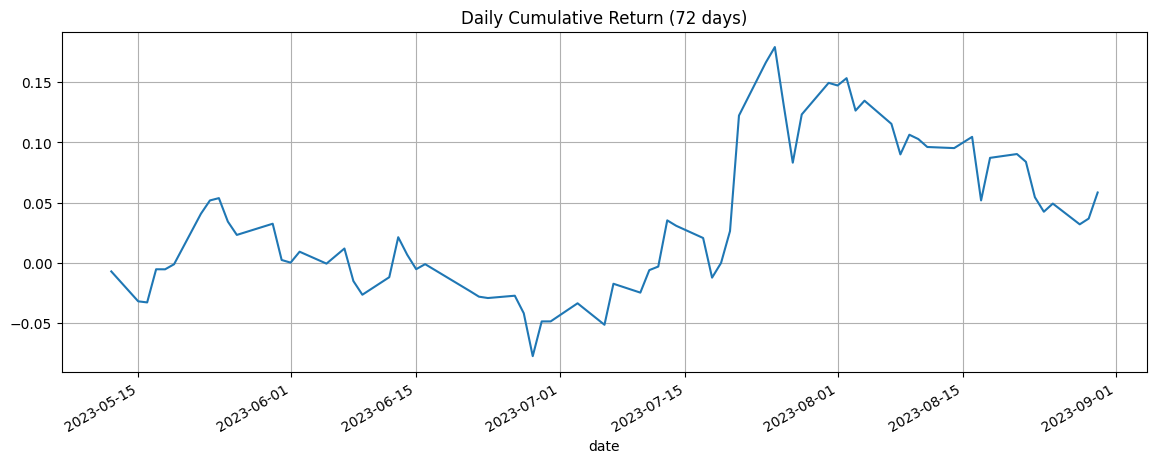

In [123]:
buy_cond[buy_cond==False] = np.nan
rtn_df = reg_rtn_1d.loc[trading_dates[0]:trading_dates[-1],:] * buy_cond

daily_rtn = rtn_df.mean(axis=1)
cum_rtn = (daily_rtn+1).cumprod()-1
cum_rtn.plot(figsize=(14,5), title='Daily Cumulative Return (72 days)', grid=True);

In [124]:
print('- 일별 추천 종목 히스토리')
print()
for date in rtn_df.index:
    stocks_in_date = rtn_df.loc[date,:]
    cond_stocks = stocks_in_date[stocks_in_date.notna()]
    print(f"{date.strftime('%Y-%m-%d')}: {cond_stocks.index.values}")

- 일별 추천 종목 히스토리

2023-05-12: ['A006220' 'A025770' 'A030960' 'A195990' 'A226330' 'A266470' 'A372800']
2023-05-15: ['A001430' 'A024880' 'A032960' 'A079810' 'A095500' 'A114190' 'A399720']
2023-05-16: ['A006220' 'A025770' 'A030960' 'A189330' 'A195990' 'A226330' 'A258790']
2023-05-17: ['A002710' 'A024880' 'A032960' 'A079810' 'A095500' 'A114190' 'A399720']
2023-05-18: ['A006220' 'A025770' 'A030960' 'A115440' 'A189330' 'A226330' 'A258790']
2023-05-19: ['A006220' 'A025770' 'A030960' 'A053800' 'A189330' 'A226330' 'A258790']
2023-05-22: ['A002710' 'A024880' 'A032960' 'A079810' 'A095500' 'A114190' 'A399720']
2023-05-23: ['A025770' 'A030960' 'A053800' 'A115440' 'A189330' 'A226330' 'A258790']
2023-05-24: ['A002710' 'A024880' 'A032960' 'A079810' 'A095500' 'A114190' 'A399720']
2023-05-25: ['A002710' 'A024880' 'A032960' 'A079810' 'A095500' 'A114190' 'A399720']
2023-05-26: ['A006220' 'A025770' 'A053800' 'A189330' 'A226330' 'A258790' 'A266470']
2023-05-30: ['A000040' 'A025770' 'A106240' 'A198080' 'A2263